# RQ3.1: Which parameters can help estimate energy consumption?

Author: Santiago del Rey

## Import libraries


In [38]:
import os
import sys

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg
import scikit_posthocs as sp
import seaborn as sns
from cliffs_delta import cliffs_delta

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.features.analysis import test_assumptions, eta_squared

from src.environment import CONFIGS_DIR, FIGURES_DIR, METRICS_DIR
from src.features.preprocessing import MJOULES_TO_KJOULES

SAVE_FIGS = True
FIGURES_FORMAT = "pdf"
SAVE_FIGS_DIR = FIGURES_DIR / FIGURES_FORMAT

if not SAVE_FIGS_DIR.exists():
    os.makedirs(SAVE_FIGS_DIR)

%matplotlib inline

sns.set_theme(style="whitegrid", context="paper", palette="colorblind", color_codes=True, font_scale=1.5)
plt.style.use(CONFIGS_DIR / "figures.mplstyle")

## Load the dataset


In [39]:
analysis_df = pd.read_parquet(
    os.path.join(METRICS_DIR, "processed", "clean-dl-training-energy-consumption-dataset.gzip"),
    columns=[
        "training environment",
        "architecture",
        "dataset",
        "image size",
        "batch size",
        "run_id",
        "training duration (h)",
        "average gpu power (W)",
        "total ram (GB)",
        "average ram used (MB)",
        "average ram power (W)",
        "energy (MJ)",
        "total seen images",
        "trained epochs",
        "accuracy",
    ],
)

analysis_df["energy (kJ)"] = analysis_df["energy (MJ)"] * MJOULES_TO_KJOULES
analysis_df["training duration (min)"] = analysis_df["training duration (h)"] * 60
analysis_df["average power (W)"] = analysis_df["average gpu power (W)"] + analysis_df["average ram power (W)"]

analysis_df.head()

,training environment,architecture,dataset,image size,batch size,run_id,training duration (h),average gpu power (W),total ram (GB),average ram used (MB),average ram power (W),energy (MJ),total seen images,trained epochs,accuracy,energy (kJ),training duration (min),average power (W)
0,Cloud,mobilenet_v2,chesslive-occupancy,"(128, 128)",32,ed5f9d5907ee495fb655e7e90aff1fac,0.735028,156.930408,16.0,12540.659180,4.702747,0.427733,2919872,89,0.975629,427.733084,44.101700,161.633156
1,Cloud,mobilenet_v2,chesslive-occupancy,"(128, 128)",32,782109dee17a4c399030b0822155591f,0.796192,153.356494,16.0,12836.668945,4.813751,0.453448,3123584,93,0.971108,453.448293,47.771517,158.170246
2,Cloud,mobilenet_v2,chesslive-occupancy,"(128, 128)",32,b85c1287f4344b7996bffcd15d890d86,0.472226,150.298999,16.0,12876.376953,4.828642,0.263805,1867360,56,0.960397,263.804732,28.333583,155.127641
3,Cloud,mobilenet_v2,chesslive-occupancy,"(128, 128)",32,5a4800e73d8241b19bb9369dd74295f9,0.634343,156.511394,16.0,12909.406250,4.841027,0.368561,2512448,75,0.974941,368.561007,38.060583,161.352421
4,Cloud,mobilenet_v2,chesslive-occupancy,"(128, 128)",32,29bb5be7abd140b68c106c87604df9a9,0.662704,149.651426,16.0,12947.494141,4.855310,0.368695,2580352,77,0.968553,368.694761,39.762217,154.506737


## Impact of batch size

In [40]:
caltech101_inception_v3 = analysis_df.query("architecture == 'inception_v3' and dataset == 'caltech101'")
stanford_dogs_inception_v3 = analysis_df.query("architecture == 'inception_v3' and dataset == 'stanford_dogs'")

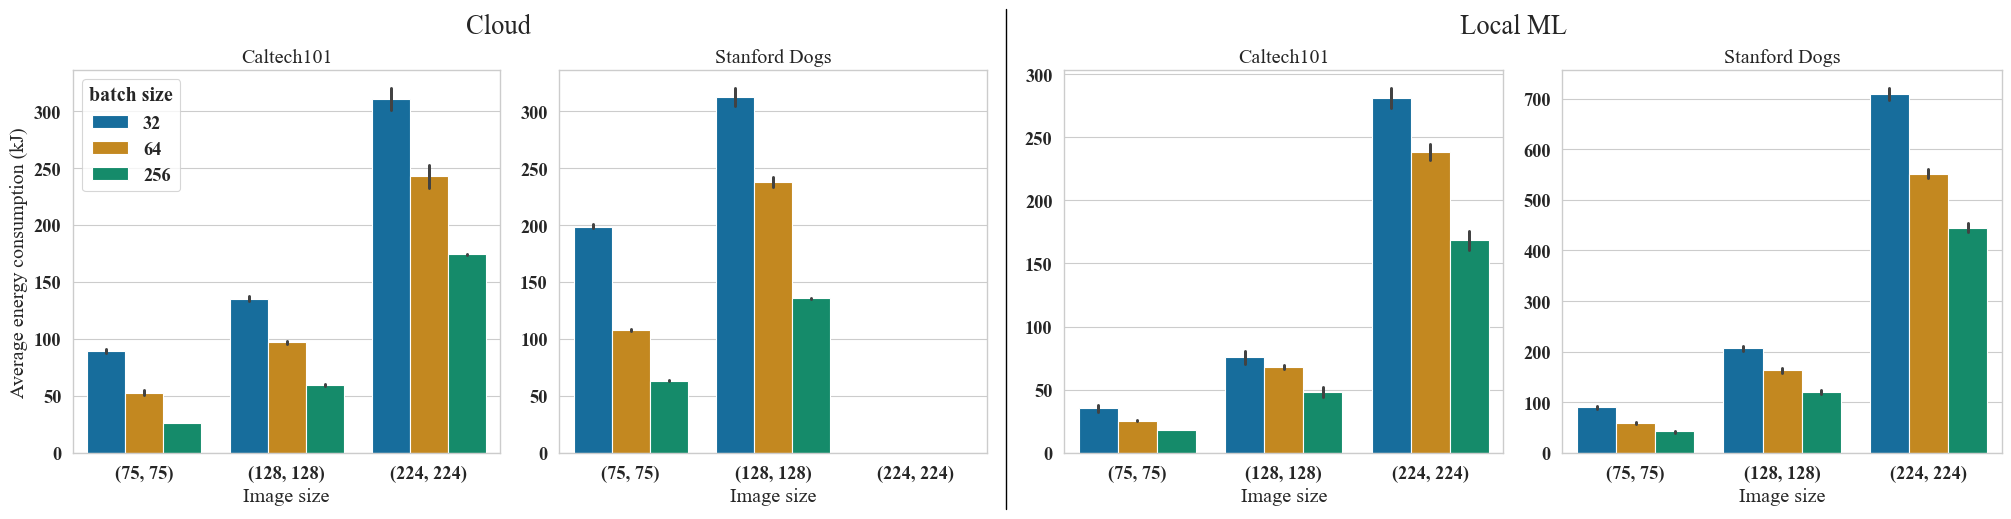

In [41]:
fig = plt.figure(figsize=(20, 5), layout="constrained")
subfigs = fig.subfigures(1, 2, wspace=0.03)

subfigs[0].suptitle("Cloud")
ax = subfigs[0].add_subplot(121)
sns.barplot(
    data=caltech101_inception_v3.query("`training environment` == 'Cloud'"),
    x="image size",
    y="energy (kJ)",
    estimator="mean",
    hue="batch size",
    order=["(75, 75)", "(128, 128)", "(224, 224)"],
    palette="colorblind",
    ax=ax,
)
ax.set_ylabel("Average energy consumption (kJ)")
ax.set_xlabel("Image size")
ax.set_title("Caltech101")

ax = subfigs[0].add_subplot(122)
sns.barplot(
    data=stanford_dogs_inception_v3.query("`training environment` == 'Cloud'"),
    x="image size",
    y="energy (kJ)",
    estimator="mean",
    hue="batch size",
    order=["(75, 75)", "(128, 128)", "(224, 224)"],
    palette="colorblind",
    ax=ax,
)
ax.set_ylabel("")
ax.set_xlabel("Image size")
ax.set_title("Stanford Dogs")
ax.legend_.remove()

# Draw a separator line between the cloud and local ML
fig.add_artist(plt.Line2D((0.5, 0.5), (0, 1), linewidth=1, color="black", linestyle="-"))

subfigs[1].suptitle("Local ML")
ax = subfigs[1].add_subplot(121)
sns.barplot(
    data=caltech101_inception_v3.query("`training environment` == 'Local ML Engineer'"),
    x="image size",
    y="energy (kJ)",
    estimator="mean",
    hue="batch size",
    order=["(75, 75)", "(128, 128)", "(224, 224)"],
    palette="colorblind",
    ax=ax,
)
ax.set_ylabel("")
ax.set_xlabel("Image size")
ax.set_title("Caltech101")
ax.legend_.remove()

ax = subfigs[1].add_subplot(122)
sns.barplot(
    data=stanford_dogs_inception_v3.query("`training environment` == 'Local ML Engineer'"),
    x="image size",
    y="energy (kJ)",
    estimator="mean",
    hue="batch size",
    order=["(75, 75)", "(128, 128)", "(224, 224)"],
    palette="colorblind",
    ax=ax,
)
ax.set_ylabel("")
ax.set_xlabel("Image size")
ax.set_title("Stanford Dogs")
ax.legend_.remove()

if SAVE_FIGS:
    fig.savefig(
        os.path.join(SAVE_FIGS_DIR, f"batch-and-input-size-effect-energy.{FIGURES_FORMAT}"), format=FIGURES_FORMAT
    )

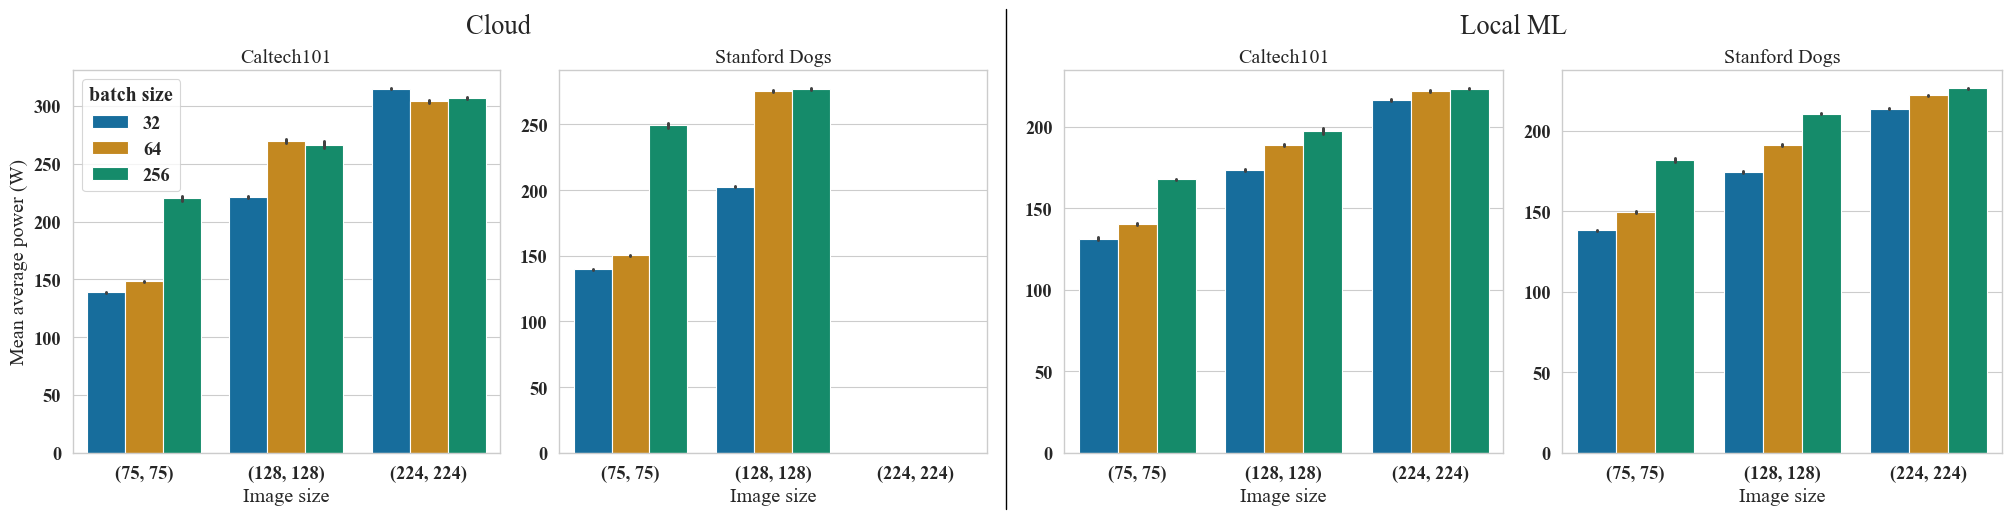

In [42]:
fig = plt.figure(figsize=(20, 5), layout="constrained")
subfigs = fig.subfigures(1, 2, wspace=0.03)

subfigs[0].suptitle("Cloud")
ax = subfigs[0].add_subplot(121)
sns.barplot(
    data=caltech101_inception_v3.query("`training environment` == 'Cloud'"),
    x="image size",
    y="average power (W)",
    estimator="mean",
    hue="batch size",
    order=["(75, 75)", "(128, 128)", "(224, 224)"],
    palette="colorblind",
    ax=ax,
)
ax.set_ylabel("Mean average power (W)")
ax.set_xlabel("Image size")
ax.set_title("Caltech101")

ax = subfigs[0].add_subplot(122)
sns.barplot(
    data=stanford_dogs_inception_v3.query("`training environment` == 'Cloud'"),
    x="image size",
    y="average power (W)",
    estimator="mean",
    hue="batch size",
    order=["(75, 75)", "(128, 128)", "(224, 224)"],
    palette="colorblind",
    ax=ax,
)
ax.set_ylabel("")
ax.set_xlabel("Image size")
ax.set_title("Stanford Dogs")
ax.legend_.remove()

# Draw a separator line between the cloud and local ML
fig.add_artist(plt.Line2D((0.5, 0.5), (0, 1), linewidth=1, color="black", linestyle="-"))

subfigs[1].suptitle("Local ML")
ax = subfigs[1].add_subplot(121)
sns.barplot(
    data=caltech101_inception_v3.query("`training environment` == 'Local ML Engineer'"),
    x="image size",
    y="average power (W)",
    estimator="mean",
    hue="batch size",
    order=["(75, 75)", "(128, 128)", "(224, 224)"],
    palette="colorblind",
    ax=ax,
)
ax.set_ylabel("")
ax.set_xlabel("Image size")
ax.set_title("Caltech101")
ax.legend_.remove()

ax = subfigs[1].add_subplot(122)
sns.barplot(
    data=stanford_dogs_inception_v3.query("`training environment` == 'Local ML Engineer'"),
    x="image size",
    y="average power (W)",
    estimator="mean",
    hue="batch size",
    order=["(75, 75)", "(128, 128)", "(224, 224)"],
    palette="colorblind",
    ax=ax,
)
ax.set_ylabel("")
ax.set_xlabel("Image size")
ax.set_title("Stanford Dogs")
ax.legend_.remove()

if SAVE_FIGS:
    fig.savefig(
        os.path.join(SAVE_FIGS_DIR, f"batch-and-input-size-effect-power.{FIGURES_FORMAT}"), format=FIGURES_FORMAT
    )

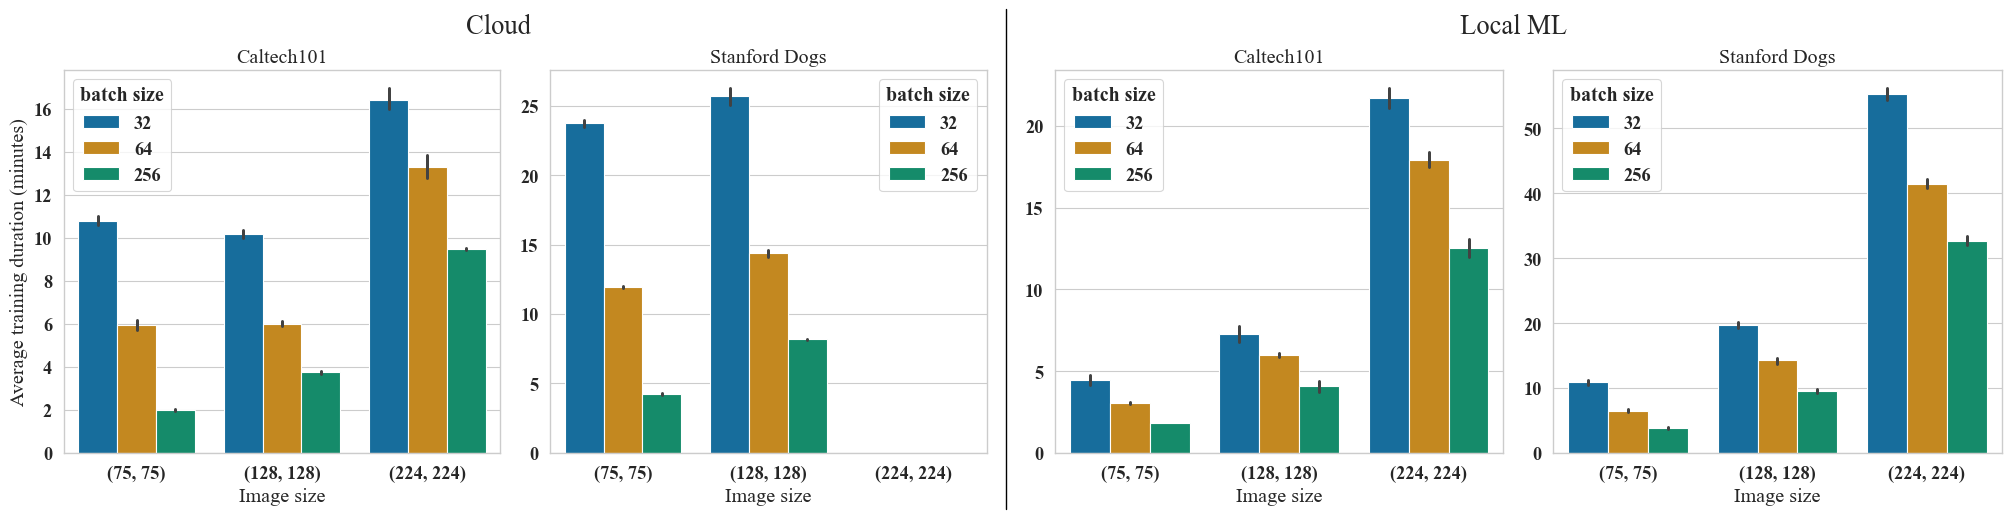

In [43]:
fig = plt.figure(figsize=(20, 5), layout="constrained")
subfigs = fig.subfigures(1, 2, wspace=0.03)

subfigs[0].suptitle("Cloud")
ax = subfigs[0].add_subplot(121)
sns.barplot(
    data=caltech101_inception_v3.query("`training environment` == 'Cloud'"),
    x="image size",
    y="training duration (min)",
    estimator="mean",
    hue="batch size",
    order=["(75, 75)", "(128, 128)", "(224, 224)"],
    palette="colorblind",
    ax=ax,
)
ax.set_ylabel("Average training duration (minutes)")
ax.set_xlabel("Image size")
ax.set_title("Caltech101")

ax = subfigs[0].add_subplot(122)
sns.barplot(
    data=stanford_dogs_inception_v3.query("`training environment` == 'Cloud'"),
    x="image size",
    y="training duration (min)",
    estimator="mean",
    hue="batch size",
    order=["(75, 75)", "(128, 128)", "(224, 224)"],
    palette="colorblind",
    ax=ax,
)
ax.set_ylabel("")
ax.set_xlabel("Image size")
ax.set_title("Stanford Dogs")

# Draw a separator line between the cloud and local ML
fig.add_artist(plt.Line2D((0.5, 0.5), (0, 1), linewidth=1, color="black", linestyle="-"))

subfigs[1].suptitle("Local ML")
ax = subfigs[1].add_subplot(121)
sns.barplot(
    data=caltech101_inception_v3.query("`training environment` == 'Local ML Engineer'"),
    x="image size",
    y="training duration (min)",
    estimator="mean",
    hue="batch size",
    order=["(75, 75)", "(128, 128)", "(224, 224)"],
    palette="colorblind",
    ax=ax,
)
ax.set_ylabel("")
ax.set_xlabel("Image size")
ax.set_title("Caltech101")

ax = subfigs[1].add_subplot(122)
sns.barplot(
    data=stanford_dogs_inception_v3.query("`training environment` == 'Local ML Engineer'"),
    x="image size",
    y="training duration (min)",
    estimator="mean",
    hue="batch size",
    order=["(75, 75)", "(128, 128)", "(224, 224)"],
    palette="colorblind",
    ax=ax,
)
ax.set_ylabel("")
ax.set_xlabel("Image size")
ax.set_title("Stanford Dogs")

if SAVE_FIGS:
    fig.savefig(
        os.path.join(SAVE_FIGS_DIR, f"batch-and-input-size-effect-time.{FIGURES_FORMAT}"), format=FIGURES_FORMAT
    )

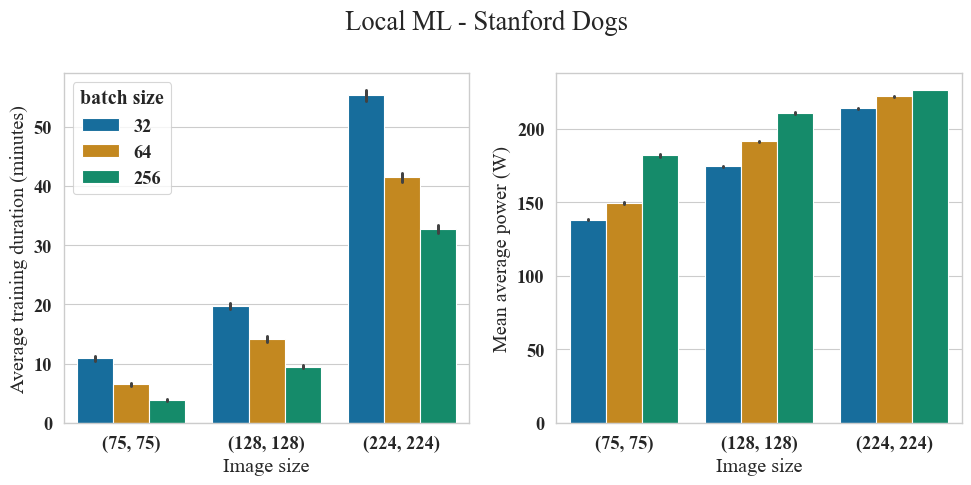

In [44]:
# Plot the effect of batch size and image size on average power and training duration for the Local ML Engineer/Gamer training environment and the Stanford Dogs dataset
fig = plt.figure(figsize=(10, 5), layout="tight")

fig.suptitle("Local ML - Stanford Dogs")
ax = fig.add_subplot(122)
sns.barplot(
    data=stanford_dogs_inception_v3.query("`training environment` == 'Local ML Engineer'"),
    x="image size",
    y="average power (W)",
    estimator="mean",
    hue="batch size",
    order=["(75, 75)", "(128, 128)", "(224, 224)"],
    palette="colorblind",
    ax=ax,
)
ax.set_ylabel("Mean average power (W)")
ax.set_xlabel("Image size")
ax.legend_.remove()

ax = fig.add_subplot(121)
sns.barplot(
    data=stanford_dogs_inception_v3.query("`training environment` == 'Local ML Engineer'"),
    x="image size",
    y="training duration (min)",
    estimator="mean",
    hue="batch size",
    order=["(75, 75)", "(128, 128)", "(224, 224)"],
    palette="colorblind",
    ax=ax,
)
ax.set_ylabel("Average training duration (minutes)")
ax.set_xlabel("Image size")

if SAVE_FIGS:
    fig.savefig(
        os.path.join(SAVE_FIGS_DIR, f"batch-and-input-size-effect-power-and-time-local-ml.{FIGURES_FORMAT}"),
        format=FIGURES_FORMAT,
    )

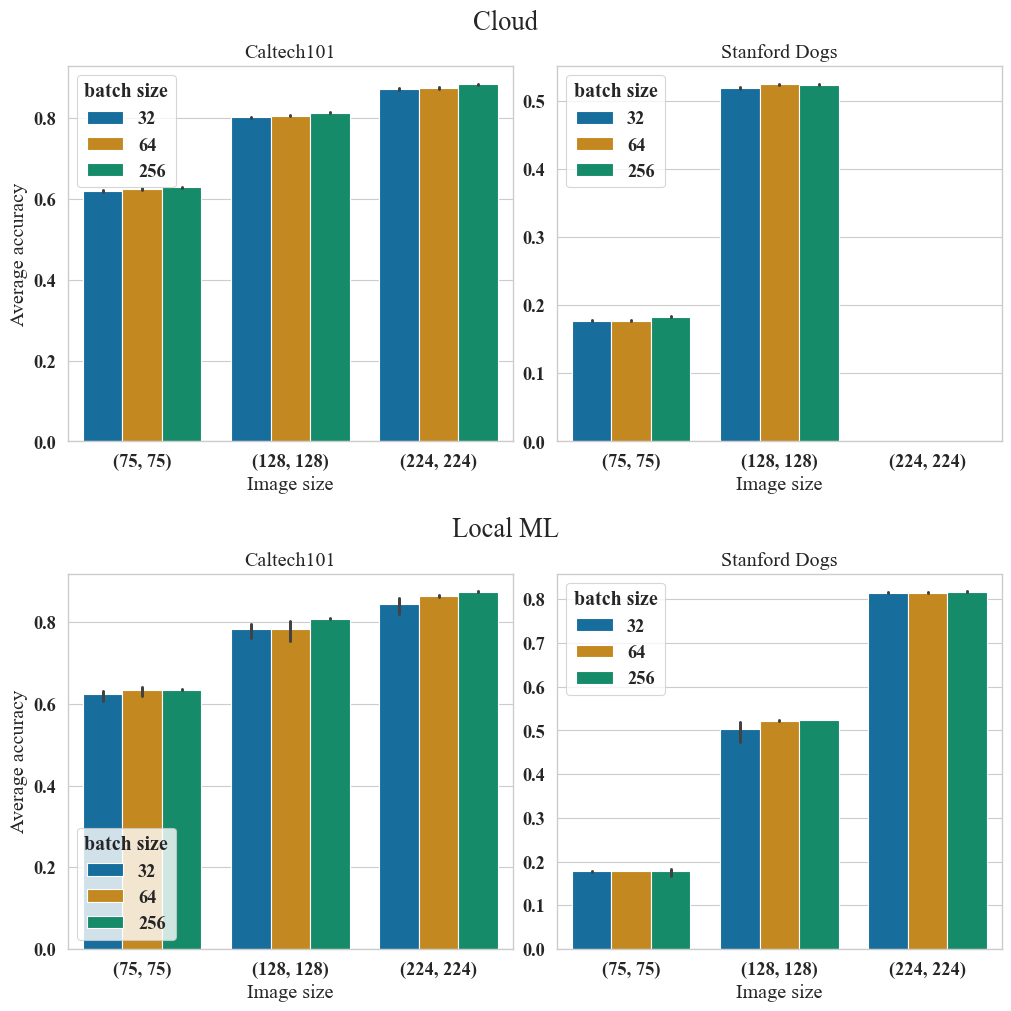

In [45]:
fig = plt.figure(figsize=(10, 10), layout="constrained")
subfigs = fig.subfigures(2, 1, hspace=0.03)

subfigs[0].suptitle("Cloud")
ax = subfigs[0].add_subplot(121)
sns.barplot(
    data=caltech101_inception_v3.query("`training environment` == 'Cloud'"),
    x="image size",
    y="accuracy",
    estimator="mean",
    hue="batch size",
    order=["(75, 75)", "(128, 128)", "(224, 224)"],
    palette="colorblind",
    ax=ax,
)
ax.set_ylabel("Average accuracy")
ax.set_xlabel("Image size")
ax.set_title("Caltech101")

ax = subfigs[0].add_subplot(122)
sns.barplot(
    data=stanford_dogs_inception_v3.query("`training environment` == 'Cloud'"),
    x="image size",
    y="accuracy",
    estimator="mean",
    hue="batch size",
    order=["(75, 75)", "(128, 128)", "(224, 224)"],
    palette="colorblind",
    ax=ax,
)
ax.set_ylabel("")
ax.set_xlabel("Image size")
ax.set_title("Stanford Dogs")

subfigs[1].suptitle("Local ML")
ax = subfigs[1].add_subplot(121)
sns.barplot(
    data=caltech101_inception_v3.query("`training environment` == 'Local ML Engineer'"),
    x="image size",
    y="accuracy",
    estimator="mean",
    hue="batch size",
    order=["(75, 75)", "(128, 128)", "(224, 224)"],
    palette="colorblind",
    ax=ax,
)
ax.set_ylabel("Average accuracy")
ax.set_xlabel("Image size")
ax.set_title("Caltech101")

ax = subfigs[1].add_subplot(122)
sns.barplot(
    data=stanford_dogs_inception_v3.query("`training environment` == 'Local ML Engineer'"),
    x="image size",
    y="accuracy",
    estimator="mean",
    hue="batch size",
    order=["(75, 75)", "(128, 128)", "(224, 224)"],
    palette="colorblind",
    ax=ax,
)
ax.set_ylabel("")
ax.set_xlabel("Image size")
ax.set_title("Stanford Dogs")

if SAVE_FIGS:
    fig.savefig(
        os.path.join(SAVE_FIGS_DIR, f"batch-and-input-size-effect-accuracy.{FIGURES_FORMAT}"), format=FIGURES_FORMAT
    )

## Impact of RAM

In [46]:
ram_experiments = analysis_df.query(
    "`training environment` == 'Cloud' and architecture == 'inception_v3' and dataset == 'stanford_dogs' and `image size` == '(128, 128)' and `batch size` == 256",
)

/home/santiago/.cache/pypoetry/virtualenvs/seaa2023-ect-extension-5MNfinQm-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/santiago/.cache/pypoetry/virtualenvs/seaa2023-ect-extension-5MNfinQm-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/santiago/.cache/pypoetry/virtualenvs/seaa2023-ect-extension-5MNfinQm-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(na

<Axes: xlabel='trained epochs', ylabel='Count'>

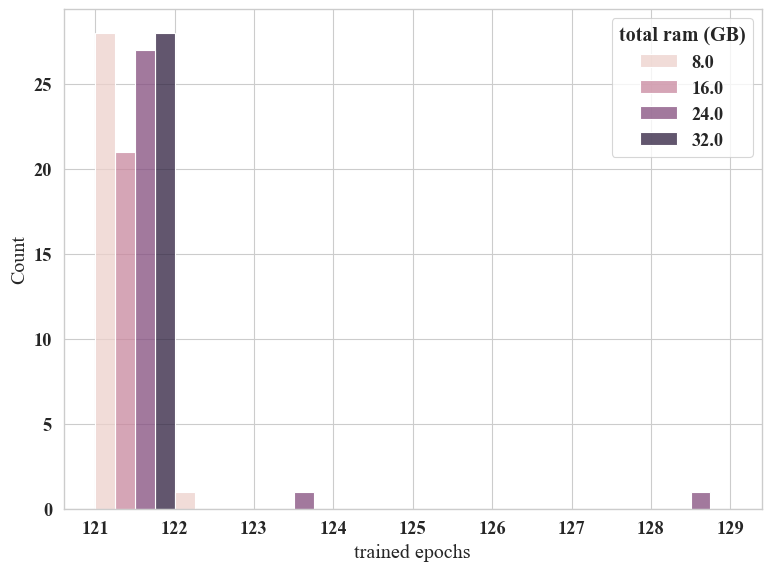

In [47]:
# Plot count of runs per trained epochs and split by total ram
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(data=ram_experiments, x="trained epochs", hue="total ram (GB)", multiple="dodge", ax=ax)

/tmp/ipykernel_7287/1807781996.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ram_experiments["energy (kJ)"] = ram_experiments["energy (MJ)"] * MJOULES_TO_KJOULES


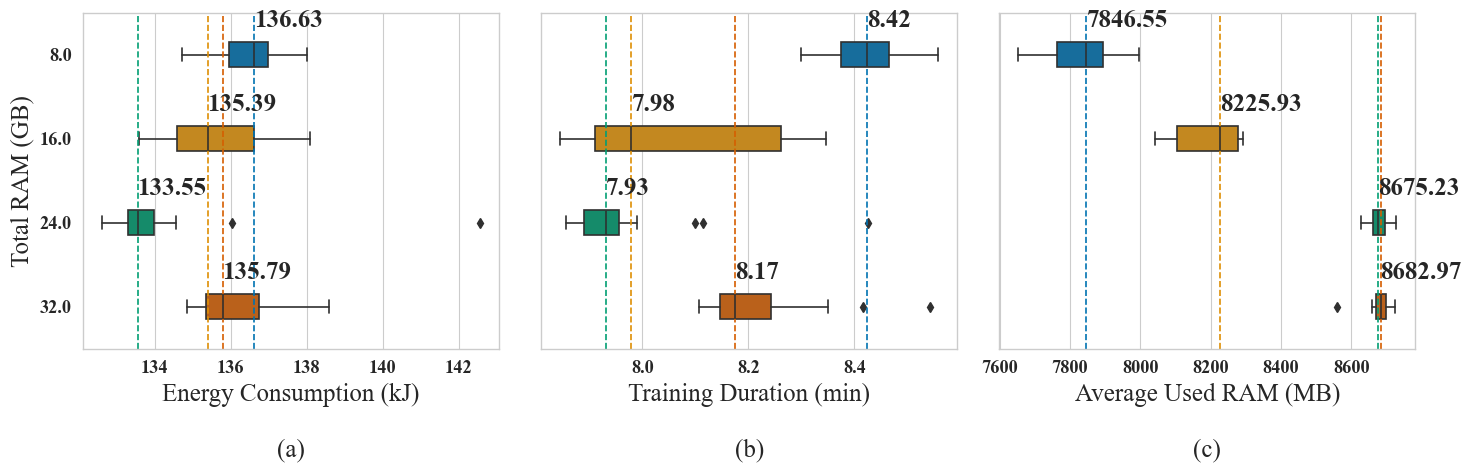

In [92]:
ram_experiments["energy (kJ)"] = ram_experiments["energy (MJ)"] * MJOULES_TO_KJOULES

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))


# Box plot of energy consumption per total ram
sns.boxplot(
    data=ram_experiments,
    x="energy (kJ)",
    y="total ram (GB)",
    orient="h",
    width=0.3,
    ax=ax1,
    hue="total ram (GB)",
    palette="colorblind",
    dodge=False,
)
ax1.legend_.remove()

# Draw a horizontal line at the median of the energy consumption for each total ram and add the median value as text
medians = ram_experiments.groupby("total ram (GB)")["energy (kJ)"].median()
for i, median in enumerate(medians):
    ax1.axvline(median, ls="--", color=f"C{i}")
    ax1.annotate(
        f"{median:.2f}", xy=(median, i), xycoords="data", xytext=(0, 20), textcoords="offset points", fontsize=18
    )

ax1.set_xlabel("Energy Consumption (kJ)\n\n(a)", fontsize=18)
ax1.set_ylabel("Total RAM (GB)", fontsize=18)

# Box plot of training duration per total ram
sns.boxplot(
    data=ram_experiments,
    x="training duration (min)",
    y="total ram (GB)",
    orient="h",
    width=0.3,
    ax=ax2,
    hue="total ram (GB)",
    palette="colorblind",
    dodge=False,
)
ax2.legend_.remove()

# Draw a horizontal line at the median of the training duration for each total ram and add the median value as text
medians = ram_experiments.groupby("total ram (GB)")["training duration (min)"].median()
for i, median in enumerate(medians):
    ax2.axvline(median, ls="--", color=f"C{i}")
    ax2.annotate(
        f"{median:.2f}", xy=(median, i), xycoords="data", xytext=(0, 20), textcoords="offset points", fontsize=18
    )

ax2.set_xlabel("Training Duration (min)\n\n(b)", fontsize=18)
ax2.set_ylabel("")
ax2.set_yticklabels([])
ax2.set_yticks([])

# Box plot of average used ram per total ram
sns.boxplot(
    data=ram_experiments,
    x="average ram used (MB)",
    y="total ram (GB)",
    orient="h",
    width=0.3,
    ax=ax3,
    hue="total ram (GB)",
    palette="colorblind",
    dodge=False,
)
ax3.legend_.remove()

# Draw a horizontal line at the median of the average used ram for each total ram and add the median value as text
medians = ram_experiments.groupby("total ram (GB)")["average ram used (MB)"].median()
for i, median in enumerate(medians):
    ax3.axvline(median, ls="--", color=f"C{i}")
    ax3.annotate(
        f"{median:.2f}", xy=(median, i), xycoords="data", xytext=(0, 20), textcoords="offset points", fontsize=18
    )

ax3.set_xlabel("Average Used RAM (MB)\n\n(c)", fontsize=18)
ax3.set_ylabel("")
ax3.set_yticklabels([])
ax3.set_yticks([])

if SAVE_FIGS:
    fig.savefig(
        os.path.join(SAVE_FIGS_DIR, "ram-impact.pdf"),
        format=FIGURES_FORMAT,
        bbox_inches="tight",
    )

/tmp/ipykernel_7287/3738010312.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ram_experiments["training duration (min)"] = ram_experiments["training duration (h)"] * 60


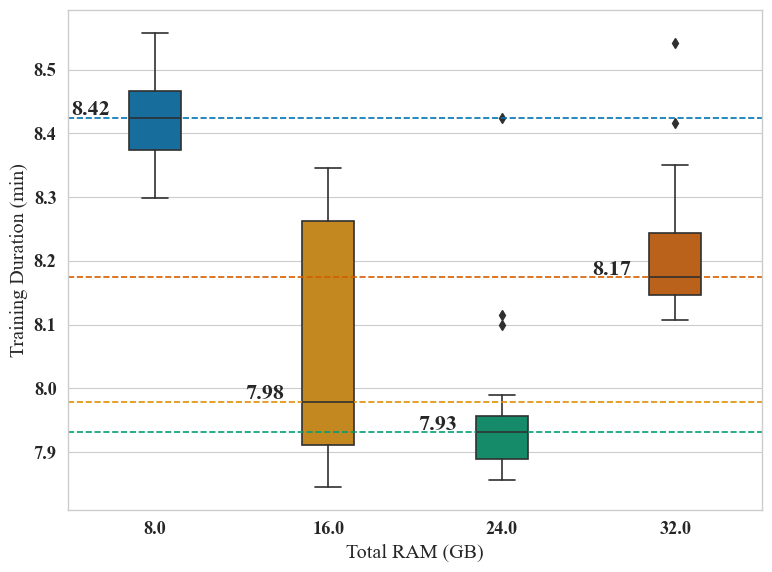

In [49]:
ram_experiments["training duration (min)"] = ram_experiments["training duration (h)"] * 60

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.boxplot(
    data=ram_experiments,
    x="total ram (GB)",
    y="training duration (min)",
    width=0.3,
    ax=ax,
    hue="total ram (GB)",
    palette="colorblind",
    dodge=False,
)
ax.legend_.remove()

# Draw a horizontal line at the median of the energy consumption for each total ram and add the median value as text
means = ram_experiments.groupby("total ram (GB)")["training duration (min)"].median()
for i, median in enumerate(means):
    ax.axhline(median, ls="--", color=f"C{i}")
    ax.annotate(f"{median:.2f}", xy=(i, median), xycoords="data", xytext=(-60, 2), textcoords="offset points")

ax.set_xlabel("Total RAM (GB)")
ax.set_ylabel("Training Duration (min)")

if SAVE_FIGS:
    fig.savefig(
        os.path.join(SAVE_FIGS_DIR, "training-duration-box-plot.pdf"),
        format=FIGURES_FORMAT,
        bbox_inches="tight",
    )

/tmp/ipykernel_7287/1646424444.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ram_experiments["average used ram (GB)"] = ram_experiments["average ram used (MB)"] / 1024


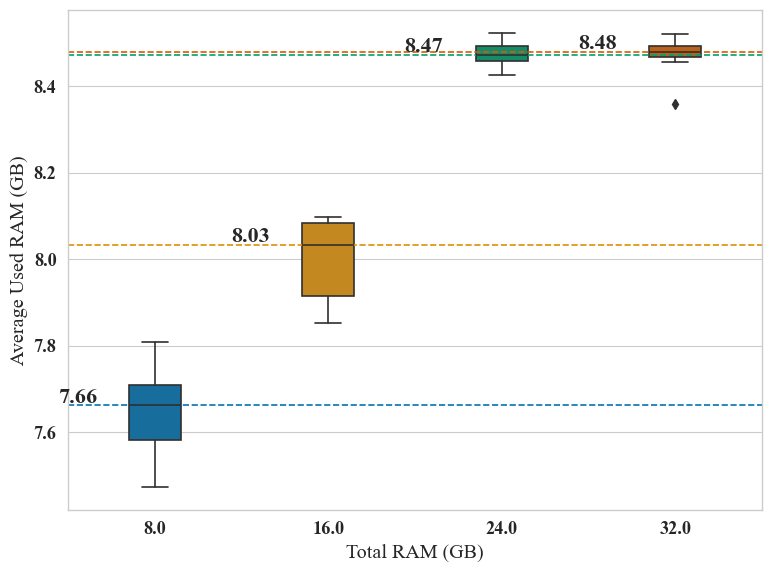

In [50]:
ram_experiments["average used ram (GB)"] = ram_experiments["average ram used (MB)"] / 1024

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.boxplot(
    data=ram_experiments,
    x="total ram (GB)",
    y="average used ram (GB)",
    width=0.3,
    ax=ax,
    hue="total ram (GB)",
    palette="colorblind",
    dodge=False,
)
ax.legend_.remove()

# Draw a horizontal line at the median of the energy consumption for each total ram and add the median value as text
means = ram_experiments.groupby("total ram (GB)")["average used ram (GB)"].median()
for i, median in enumerate(means):
    ax.axhline(median, ls="--", color=f"C{i}")
    ax.annotate(f"{median:.2f}", xy=(i, median), xycoords="data", xytext=(-70, 2), textcoords="offset points")

ax.set_xlabel("Total RAM (GB)")
ax.set_ylabel("Average Used RAM (GB)")

if SAVE_FIGS:
    fig.savefig(
        os.path.join(SAVE_FIGS_DIR, "ram-used-box-plot.pdf"),
        format=FIGURES_FORMAT,
        bbox_inches="tight",
    )

In [51]:
ram_8gb = ram_experiments.query("`total ram (GB)` == 8")
ram_16gb = ram_experiments.query("`total ram (GB)` == 16")
ram_24gb = ram_experiments.query("`total ram (GB)` == 24")
ram_32gb = ram_experiments.query("`total ram (GB)` == 32")

### Does the amount of RAM impact energy consumption?


In [52]:
dependent_variable = "energy (kJ)"
independent_variable = "total ram (GB)"

Shapiro test for normality of group 0: W = 0.9862149357795715 and p-value 0.960343062877655. Is normaly distributed? True
Shapiro test for normality of group 1: W = 0.9096245169639587 and p-value 0.05398144945502281. Is normaly distributed? True
Shapiro test for normality of group 2: W = 0.4980253577232361 and p-value 7.436419480200129e-09. Is normaly distributed? False
Shapiro test for normality of group 3: W = 0.9229984283447266 and p-value 0.04116373881697655. Is normaly distributed? False
Levene test for equal variances: W = 0.9867054118058579 and p-value = 0.4021569493755536. Equal variances? True


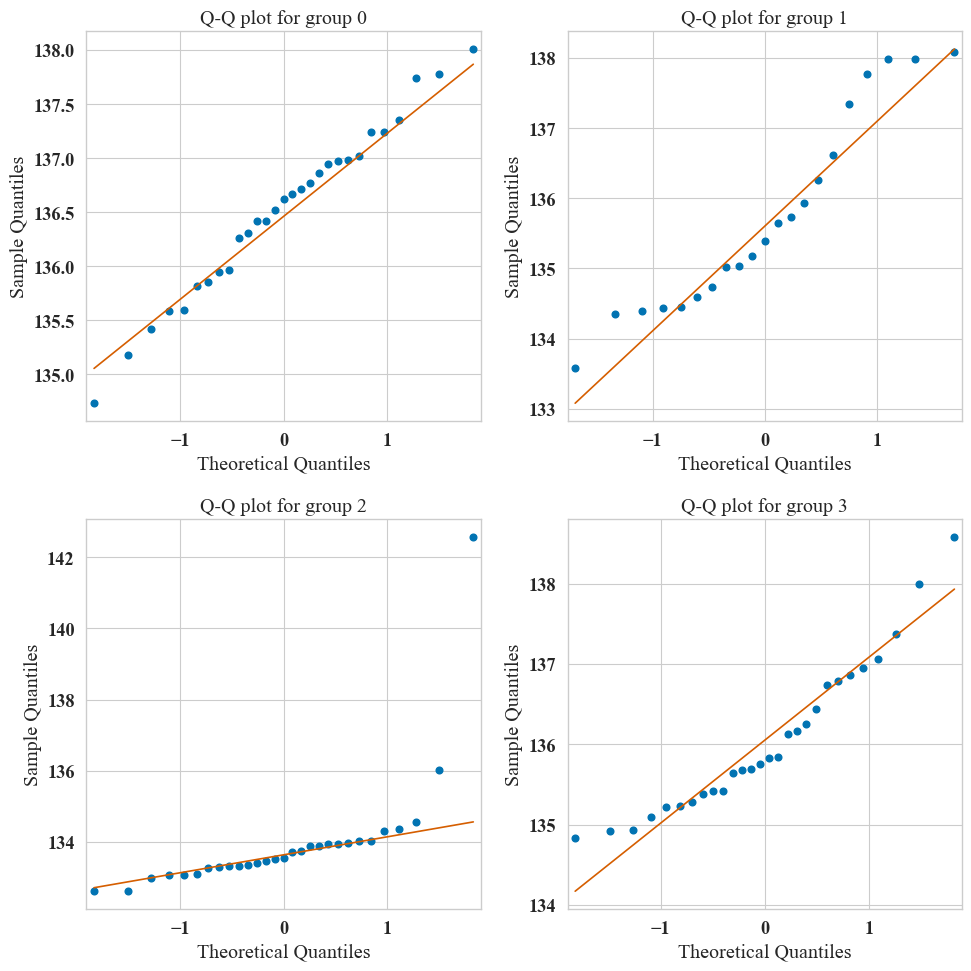

In [53]:
_ = test_assumptions(
    ram_8gb[dependent_variable],
    ram_16gb[dependent_variable],
    ram_24gb[dependent_variable],
    ram_32gb[dependent_variable],
    nrows=2,
    ncols=2,
    figsize=(10, 10),
)


#### Kruskal-Wallis test


In [54]:
result_1 = pg.kruskal(ram_experiments, dv=dependent_variable, between=independent_variable)
result_1

,Source,ddof1,H,p-unc
Kruskal,total ram (GB),3,53.63099,1.344959e-11


#### Eta-squared measure


In [55]:
eta_squared(result_1["H"].item(), ram_experiments[independent_variable].nunique(), ram_experiments.shape[0])

0.49156301281554304

#### Dunn's test


In [56]:
p_values = sp.posthoc_dunn(
    ram_experiments, val_col=dependent_variable, group_col=independent_variable, p_adjust="holm", sort=True
)

# Check which assumptions reject the null hypothesis.
p_values < 0.05

,8.0,16.0,24.0,32.0
8.0,False,False,True,False
16.0,False,False,True,False
24.0,True,True,False,True
32.0,False,False,True,False


In [57]:
print(f"8GB - 16GB effect size: {cliffs_delta(ram_8gb[dependent_variable], ram_16gb[dependent_variable])}")
print(f"8GB - 24GB effect size: {cliffs_delta(ram_8gb[dependent_variable], ram_24gb[dependent_variable])}")
print(f"8GB - 32GB effect size: {cliffs_delta(ram_8gb[dependent_variable], ram_32gb[dependent_variable])}")
print(f"16GB - 24GB effect size: {cliffs_delta(ram_16gb[dependent_variable], ram_24gb[dependent_variable])}")
print(f"16GB - 32GB effect size: {cliffs_delta(ram_16gb[dependent_variable], ram_32gb[dependent_variable])}")
print(f"24GB - 32GB effect size: {cliffs_delta(ram_24gb[dependent_variable], ram_32gb[dependent_variable])}")

8GB - 16GB effect size: (0.3957307060755337, 'medium')
8GB - 24GB effect size: (0.9096313912009513, 'large')
8GB - 32GB effect size: (0.3374384236453202, 'medium')
16GB - 24GB effect size: (0.8292282430213465, 'large')
16GB - 32GB effect size: (-0.22789115646258504, 'small')
24GB - 32GB effect size: (-0.8916256157635468, 'large')


### Does the amount of RAM impact training time?

In [58]:
dependent_variable = "training duration (min)"

Shapiro test for normality of group 0: W = 0.9707581996917725 and p-value 0.5804351568222046. Is normaly distributed? True
Shapiro test for normality of group 1: W = 0.8195891976356506 and p-value 0.0013282493455335498. Is normaly distributed? False
Shapiro test for normality of group 2: W = 0.6256523132324219 and p-value 2.1216405343693623e-07. Is normaly distributed? False
Shapiro test for normality of group 3: W = 0.8209718465805054 and p-value 0.0002559735148679465. Is normaly distributed? False
Levene test for equal variances: W = 5.012682097859182 and p-value = 0.0027673101321213154. Equal variances? False


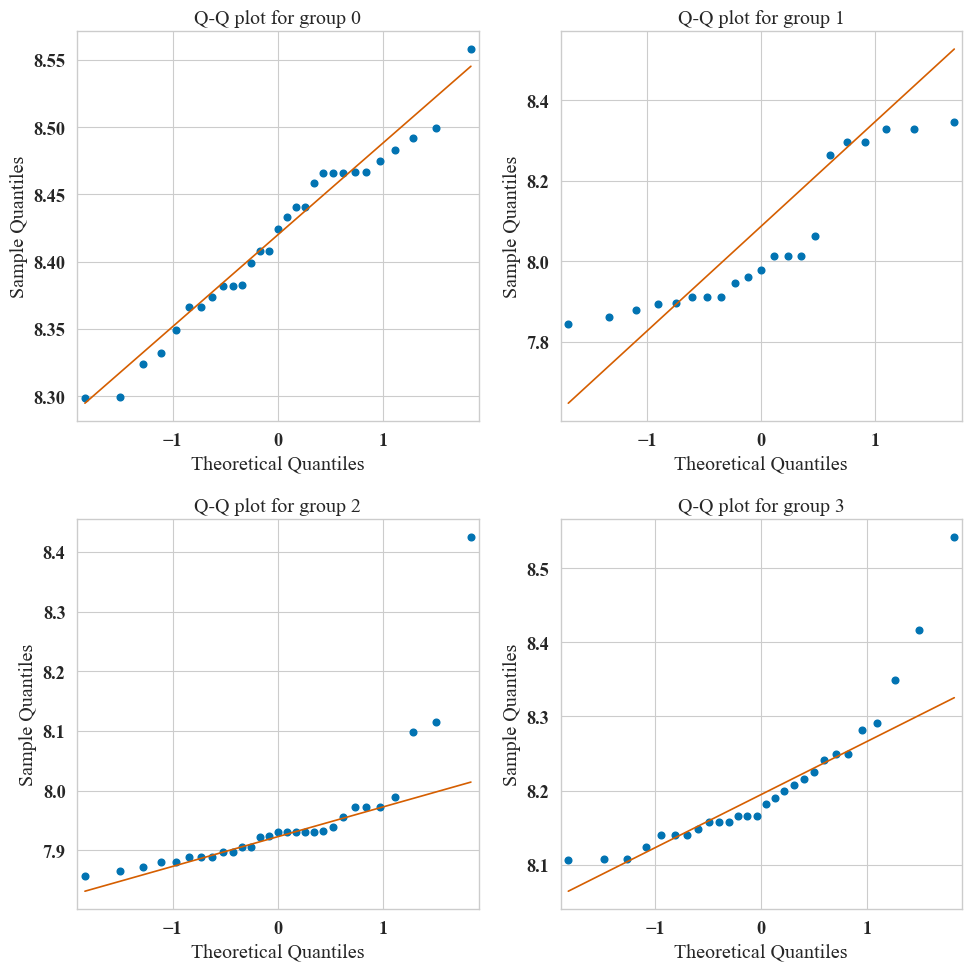

In [59]:
_ = test_assumptions(
    ram_8gb[dependent_variable],
    ram_16gb[dependent_variable],
    ram_24gb[dependent_variable],
    ram_32gb[dependent_variable],
    nrows=2,
    ncols=2,
    figsize=(10, 10),
)


#### Kruskal-Wallis test


In [60]:
result_2 = pg.kruskal(ram_experiments, dv=dependent_variable, between=independent_variable)
result_2

,Source,ddof1,H,p-unc
Kruskal,total ram (GB),3,74.456242,4.738522e-16


#### Eta-squared measure


In [61]:
eta_squared(result_2["H"].item(), ram_experiments[independent_variable].nunique(), ram_experiments.shape[0])

0.6937499183416956

#### Dunn's test


In [62]:
p_values = sp.posthoc_dunn(
    ram_experiments, val_col=dependent_variable, group_col=independent_variable, p_adjust="holm", sort=True
)

# Check which assumptions reject the null hypothesis.
p_values < 0.05

,8.0,16.0,24.0,32.0
8.0,False,True,True,True
16.0,True,False,False,True
24.0,True,False,False,True
32.0,True,True,True,False


In [63]:
print(f"8GB - 16GB effect size: {cliffs_delta(ram_8gb[dependent_variable], ram_16gb[dependent_variable])}")
print(f"8GB - 24GB effect size: {cliffs_delta(ram_8gb[dependent_variable], ram_24gb[dependent_variable])}")
print(f"8GB - 32GB effect size: {cliffs_delta(ram_8gb[dependent_variable], ram_32gb[dependent_variable])}")
print(f"16GB - 24GB effect size: {cliffs_delta(ram_16gb[dependent_variable], ram_24gb[dependent_variable])}")
print(f"16GB - 32GB effect size: {cliffs_delta(ram_16gb[dependent_variable], ram_32gb[dependent_variable])}")
print(f"24GB - 32GB effect size: {cliffs_delta(ram_24gb[dependent_variable], ram_32gb[dependent_variable])}")

8GB - 16GB effect size: (0.9671592775041051, 'large')
8GB - 24GB effect size: (0.9643281807372176, 'large')
8GB - 32GB effect size: (0.8842364532019704, 'large')
16GB - 24GB effect size: (0.30049261083743845, 'small')
16GB - 32GB effect size: (-0.4965986394557823, 'large')
24GB - 32GB effect size: (-0.9261083743842364, 'large')


### Does the amount of RAM impact the used RAM?

In [64]:
dependent_variable = "average used ram (GB)"

Shapiro test for normality of group 0: W = 0.9531124234199524 and p-value 0.2202899008989334. Is normaly distributed? True
Shapiro test for normality of group 1: W = 0.8161864876747131 and p-value 0.0011723425704985857. Is normaly distributed? False
Shapiro test for normality of group 2: W = 0.9632799625396729 and p-value 0.3947855830192566. Is normaly distributed? True
Shapiro test for normality of group 3: W = 0.7614411115646362 and p-value 2.396829950157553e-05. Is normaly distributed? False
Levene test for equal variances: W = 13.204858179391323 and p-value = 2.3195643343146905e-07. Equal variances? False


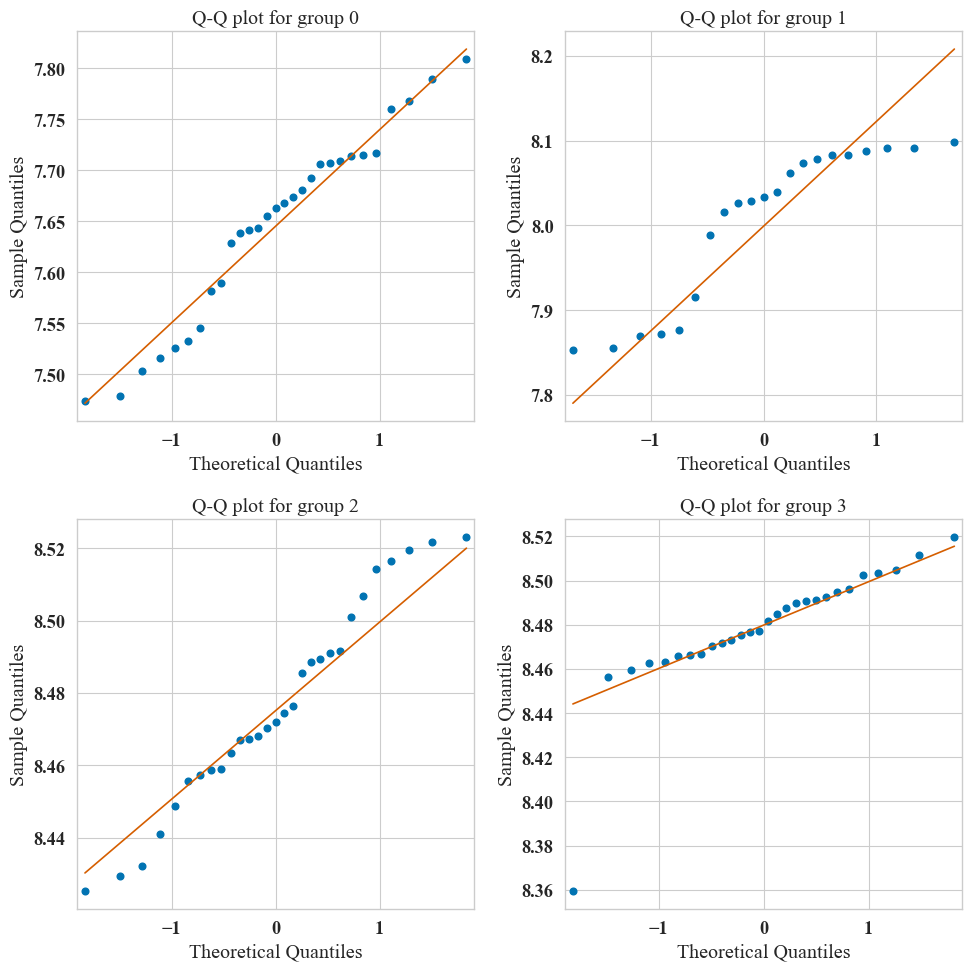

In [65]:
_ = test_assumptions(
    ram_8gb[dependent_variable],
    ram_16gb[dependent_variable],
    ram_24gb[dependent_variable],
    ram_32gb[dependent_variable],
    nrows=2,
    ncols=2,
    figsize=(10, 10),
)


#### Kruskal-Wallis test


In [66]:
result_3 = pg.kruskal(ram_experiments, dv=dependent_variable, between=independent_variable)
result_3

,Source,ddof1,H,p-unc
Kruskal,total ram (GB),3,87.24667,8.547434e-19


#### Eta-squared measure


In [67]:
eta_squared(result_3["H"].item(), ram_experiments[independent_variable].nunique(), ram_experiments.shape[0])

0.8179288338772271

#### Dunn's test


In [68]:
p_values = sp.posthoc_dunn(
    ram_experiments, val_col=dependent_variable, group_col=independent_variable, p_adjust="holm", sort=True
)

# Check which assumptions reject the null hypothesis.
p_values < 0.05

,8.0,16.0,24.0,32.0
8.0,False,True,True,True
16.0,True,False,True,True
24.0,True,True,False,False
32.0,True,True,False,False


In [69]:
print(f"8GB - 16GB effect size: {cliffs_delta(ram_8gb[dependent_variable], ram_16gb[dependent_variable])}")
print(f"8GB - 24GB effect size: {cliffs_delta(ram_8gb[dependent_variable], ram_24gb[dependent_variable])}")
print(f"8GB - 32GB effect size: {cliffs_delta(ram_8gb[dependent_variable], ram_32gb[dependent_variable])}")
print(f"16GB - 24GB effect size: {cliffs_delta(ram_16gb[dependent_variable], ram_24gb[dependent_variable])}")
print(f"16GB - 32GB effect size: {cliffs_delta(ram_16gb[dependent_variable], ram_32gb[dependent_variable])}")
print(f"24GB - 32GB effect size: {cliffs_delta(ram_24gb[dependent_variable], ram_32gb[dependent_variable])}")

8GB - 16GB effect size: (-1.0, 'large')
8GB - 24GB effect size: (-1.0, 'large')
8GB - 32GB effect size: (-1.0, 'large')
16GB - 24GB effect size: (-1.0, 'large')
16GB - 32GB effect size: (-1.0, 'large')
24GB - 32GB effect size: (-0.1206896551724138, 'negligible')
